# [IEEE Fraud Detection Competition](https://www.kaggle.com/c/ieee-fraud-detection/overview)

From the [competition overview](https://www.kaggle.com/c/ieee-fraud-detection/overview):

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Goal: 
- Basic exploritory data analysis on the IEEE Fraud Detection dataset.
- Feature Engineering and Using LGBM to Make a Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# 1. Data

In the competition I am predicting the probability that an online transaction is fraudulent, as denoted by the binary target is Fraud.

The data is broken into two files identity and transaction, which can be joined by TransactionID. 

### 1.1 Read the data

In [2]:
%%time
# Transaction CSVs
train_transaction = pd.read_csv('./data/train_transaction.csv')
test_transaction = pd.read_csv('./data/test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('./data/train_identity.csv')
test_identity = pd.read_csv('./data/test_identity.csv')

# Sample Submissions
ss = pd.read_csv('./data/sample_submission.csv')

CPU times: user 22 s, sys: 3.66 s, total: 25.7 s
Wall time: 25.9 s


In [3]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [4]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [5]:
# list(train_transaction.columns)
# list(train_identity.columns) - note "DeviceType" and "DeviceInfo"

In [6]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

### 1.2 Exam the link between transaction and identity data

In [7]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


24.4% of TransactionIDs in train (144233 / 590540) have an associated train_identity.  
28.0% of TransactionIDs in test (144233 / 590540) have an associated train_identity.

This indicates that not all transactions have corresponding identity information.

### 1.3 Data Split on "TransactionDT" (Time Series)

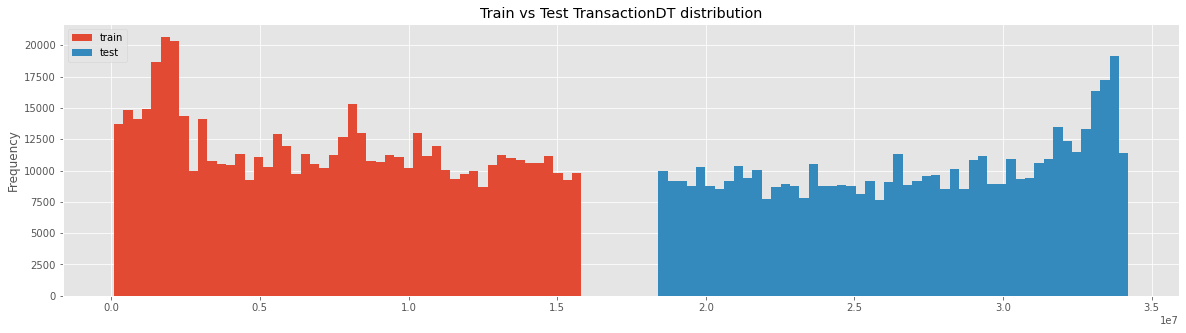

In [8]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(20, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

We can see that train and test data are split by transactionDT. The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

### 1.4 Target Distribution

In [9]:
#Check class imbalance

train_transaction['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

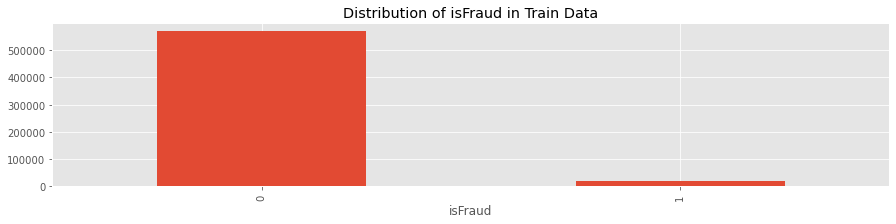

In [10]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='bar',
          title='Distribution of isFraud in Train Data',
          figsize=(15, 3))
plt.show()

Heavily imbalanced class (as expected in most fraud detection cases)

### 1.5 TransactionAmt

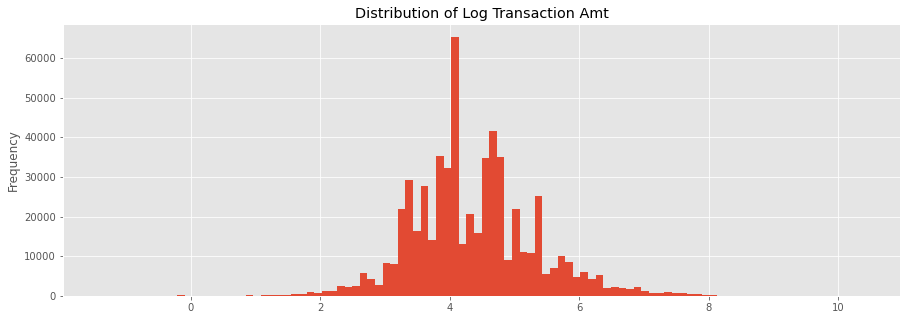

In [11]:
train_transaction.groupby("isFraud")["TransactionAmt"].apply(np.log).plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt');

In [12]:
train_transaction.groupby("isFraud")["TransactionAmt"].describe()

count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000

Normal distribution in transaction amount with similar mean (with fraud tranx to be slightly higher) and std (fraud is slightly lower) between fraud and non-fruad transaction.  

Fraud transactions have been overlapped by non-fraud so let's look at them separately. 

The transaction amounts are heavily skewed in distribution so I will try using log transformation to make it conform to normal distribution. 

Note, because of the log transfrom, any values between 0 and 1 will appear to be negative.

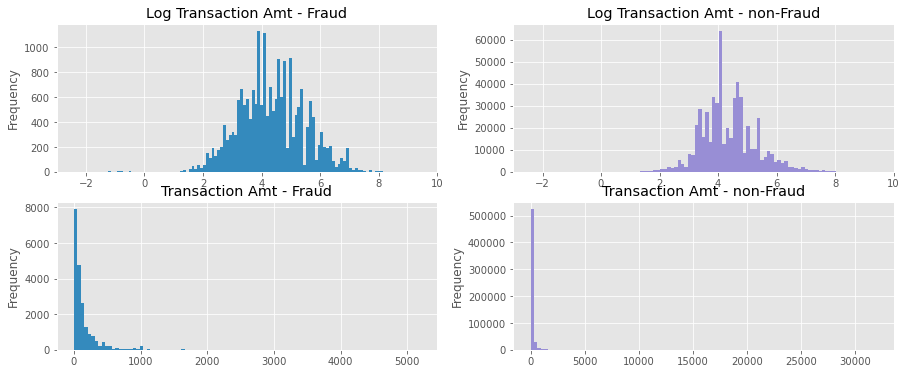

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))

train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='Log Transaction Amt - Fraud',
    color=color_pal[1],
    xlim=(-3, 10),
    ax= ax1)

train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(
    kind='hist',
    bins=100,
    title='Log Transaction Amt - non-Fraud',
    color=color_pal[2],
    xlim=(-3, 10),
    ax= ax2)

train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].plot(
    kind='hist',
    bins=100,
    title='Transaction Amt - Fraud',
    color=color_pal[1],
    ax= ax3)

train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].plot(
    kind='hist',
    bins=100,
    title='Transaction Amt - non-Fraud',
    color=color_pal[2],
    ax= ax4)
plt.show()

### 1.7 Categorical Features - Transaction


As described in project page [here](https://www.kaggle.com/c/ieee-fraud-detection/data), the following features are categorical. 

- ProductCD
- P_emaildomain
- R_emaildomain
- card1 - card6
- addr1, addr2
- M1 - M9

Let's take a look at these now.

#### 1.7.1 ProductCD

We don't exactly know what each values stands for so we will look at its relation with target value. 

In [14]:
train_transaction["ProductCD"].value_counts(normalize=True)

W    0.744522
C    0.116028
R    0.063838
H    0.055922
S    0.019690
Name: ProductCD, dtype: float64

In [15]:
train_transaction.loc[train_transaction['isFraud']==1]["ProductCD"].value_counts()

W    8969
C    8008
H    1574
R    1426
S     686
Name: ProductCD, dtype: int64

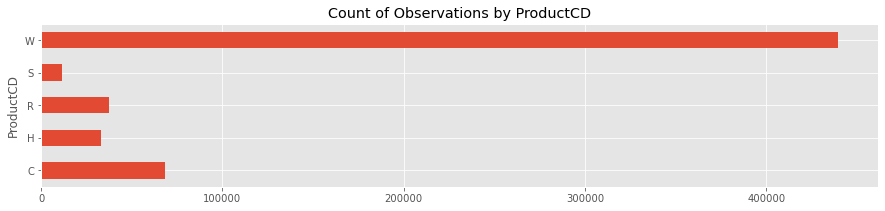

In [16]:
train_transaction.groupby('ProductCD')['TransactionID'].count().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Count of Observations by ProductCD')
plt.show()

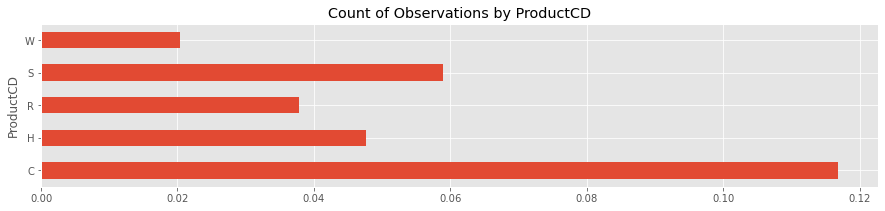

In [17]:
train_transaction.groupby('ProductCD')['isFraud'].mean().sort_index().plot(
    kind='barh',
    figsize=(15, 3),
    title='Count of Observations by ProductCD')
plt.show()

What we can see here is that transactions with ProductCD with "C" and "S" have higher % of fraud target. 

#### 1.7.2 Emaildomain  'P_emaildomain' and 'R_emaildomain'

In [18]:
[col for col in train_transaction.columns if 'email' in col]

['P_emaildomain', 'R_emaildomain']

In [19]:
p_email_domain = train_transaction['P_emaildomain'].unique()
p_email_domain

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [20]:
r_email_domain = train_transaction['R_emaildomain'].unique()
r_email_domain

array([nan, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com',
       'charter.net', 'prodigy.net.mx', 'comcast.net', 'live.com.mx',
       'icloud.com', 'yahoo.com', 'aol.com', 'juno.com', 'att.net',
       'verizon.net', 'yahoo.com.mx', 'bellsouth.net', 'servicios-ta.com',
       'ymail.com', 'hotmail.es', 'msn.com', 'optonline.net', 'live.com',
       'gmx.de', 'aim.com', 'mail.com', 'me.com', 'outlook.es', 'cox.net',
       'earthlink.net', 'embarqmail.com', 'web.de', 'sbcglobal.net',
       'scranton.edu', 'mac.com', 'twc.com', 'roadrunner.com', 'yahoo.fr',
       'yahoo.de', 'yahoo.es', 'frontiernet.net', 'gmail', 'live.fr',
       'q.com', 'yahoo.co.uk', 'windstream.net', 'suddenlink.net',
       'hotmail.fr', 'ptd.net', 'hotmail.de', 'frontier.com',
       'cfl.rr.com', 'hotmail.co.uk', 'netzero.com', 'netzero.net',
       'yahoo.co.jp', 'rocketmail.com', 'centurylink.net',
       'protonmail.com', 'cableone.net', 'sc.rr.com'], dtype=object)

There are duplicate values with different spelling so I will create a dictionary to map the values and clean the data of these two features.

In [21]:
combined_unique_email = np.concatenate([p_email_domain, r_email_domain[~np.isin(r_email_domain,p_email_domain)]])
combined_unique_email

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp', nan,
       'scranton.edu'], dtype=object)

In [22]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', \
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', \
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', \
          'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', \
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', \
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', \
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', \
          'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', \
          'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', \
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', \
          'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', \
          'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', \
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', \
          'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', \
          'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', \
          'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [23]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train_transaction[c + '_bin'] = train_transaction[c].map(emails)
    test_transaction[c + '_bin'] = test_transaction[c].map(emails)
    
    train_transaction[c + '_suffix'] = train_transaction[c].map(lambda x: str(x).split('.')[-1])
    test_transaction[c + '_suffix'] = test_transaction[c].map(lambda x: str(x).split('.')[-1])
    
    train_transaction[c + '_suffix'] = train_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_transaction[c + '_suffix'] = test_transaction[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [24]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V334  V335  V336  V337  V338 V339  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  P_emaildomain_bin  P_emaildomain_suffix  R_emaildomain_bin  \
0               NaN                   nan                NaN   
1            google                   com                NaN   
2         microsoft                   com                NaN   
3             yahoo                   com                NaN   
4            google                   com                NaN   

   R_emaildomain_suffix  
0                   nan  
1                   nan  
2                   nan  
3                   nan  
4                   nan  

[5 rows x 398 columns]

### 1.7.3 card1 - card6

In [25]:
card_cols = [col for col in train_transaction.columns if 'card' in col]
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

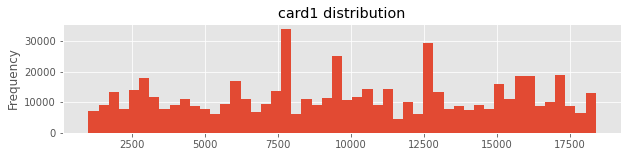

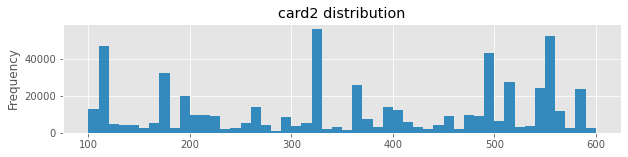

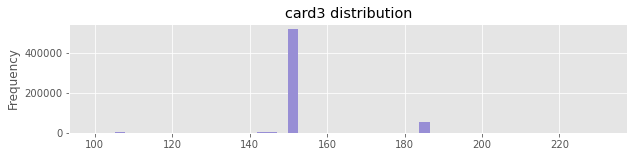

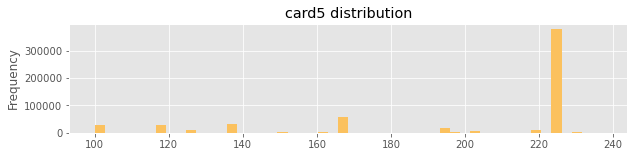

In [26]:
color_idx = 0
for col in card_cols:
    if train_transaction[col].dtype !='object':
        train_transaction[col].plot(kind='hist', bins=50, title=f'{col} distribution',
        color=color_pal[color_idx], figsize=(10, 2))
    plt.show()
    color_idx +=1

<Figure size 432x288 with 0 Axes>

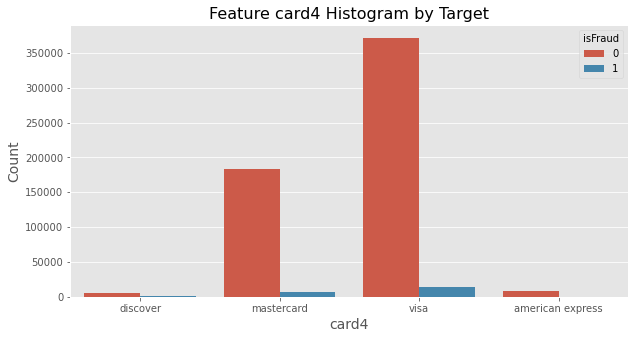

<Figure size 432x288 with 0 Axes>

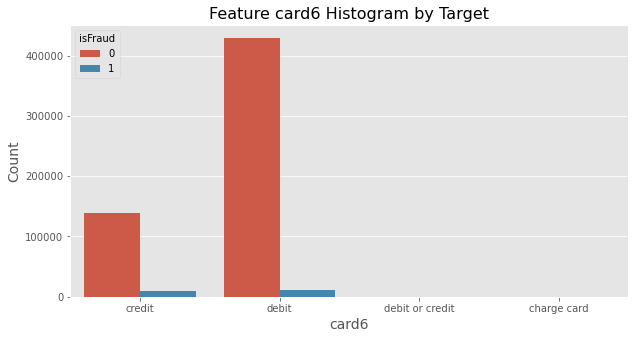

In [27]:
for col in card_cols:
    if train_transaction[col].dtype == 'object':
        plt.figure()
        fig, ax = plt.subplots(figsize=(10,5))
        sns.countplot(x=col, hue='isFraud', data=train_transaction)
    
        plt.ylabel('Count', fontsize=14)
        plt.xlabel(col, fontsize=14)
        plt.title(f'Feature {col} Histogram by Target', fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show();

Not seeing any particularly useful pattern between target groups.

### 1.7.4 addr1, addr2

Possibly representing difference addresses or region. 

In [28]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


<AxesSubplot:ylabel='Frequency'>

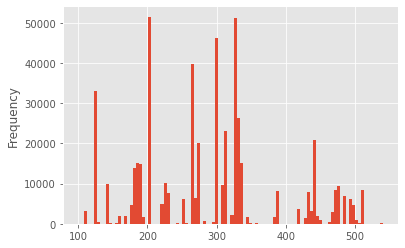

In [29]:
train_transaction.addr1.plot(kind='hist', bins=100)

In [30]:
len(train_transaction.addr1.unique())

333

"addr1" has 333 different values and the distribution is wide. 

<AxesSubplot:ylabel='Frequency'>

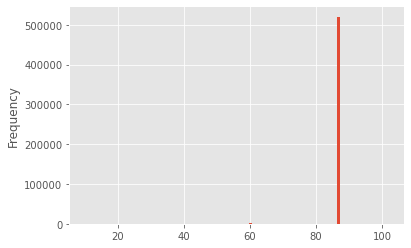

In [31]:
train_transaction.addr2.plot(kind='hist', bins=100)

In [32]:
len(train_transaction.addr2.unique())

75

In [33]:
train_transaction.addr2.value_counts(normalize=True, dropna=False)

87.0    0.881365
NaN     0.111264
60.0    0.005222
96.0    0.001080
32.0    0.000154
          ...   
22.0    0.000002
25.0    0.000002
75.0    0.000002
49.0    0.000002
77.0    0.000002
Name: addr2, Length: 75, dtype: float64

"addr2" has only 75 different values and 88% of them is 85. 11% is NaN. 

### 1.7.5 M1-M9

These features seem to be binary with an exception of "M4", which has values such as M2 and M0. 

In [198]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [182]:
m_dict = {}
for i in range(1,10):
    if i !=4:
        m_dict["m%s" %i] = train_transaction["M%s" %i].value_counts(dropna=False)

m_value_counts = pd.DataFrame(m_dict)
m_value_counts.reset_index(inplace=True)
m_value_counts

index      m1      m2      m3      m5      m6      m7      m8      m9
0     T  319415  285468  251731  107567  193324   32901   89037  205656
1   NaN  271100  271100  271100  350482  169360  346265  346252  346252
2     F      25   33972   67709  132491  227856  211374  155251   38632

In [183]:
m_value_counts = m_value_counts.melt(id_vars ='index', value_vars=[col for col in m_value_counts if 'index' not in col],
                                    var_name="m", value_name='count')
m_value_counts.replace(np.nan, "None", inplace=True)
m_value_counts.rename(columns = {'index': 'value'}, inplace=True)

In [184]:
m_value_counts

value   m   count
0      T  m1  319415
1   None  m1  271100
2      F  m1      25
3      T  m2  285468
4   None  m2  271100
5      F  m2   33972
6      T  m3  251731
7   None  m3  271100
8      F  m3   67709
9      T  m5  107567
10  None  m5  350482
11     F  m5  132491
12     T  m6  193324
13  None  m6  169360
14     F  m6  227856
15     T  m7   32901
16  None  m7  346265
17     F  m7  211374
18     T  m8   89037
19  None  m8  346252
20     F  m8  155251
21     T  m9  205656
22  None  m9  346252
23     F  m9   38632

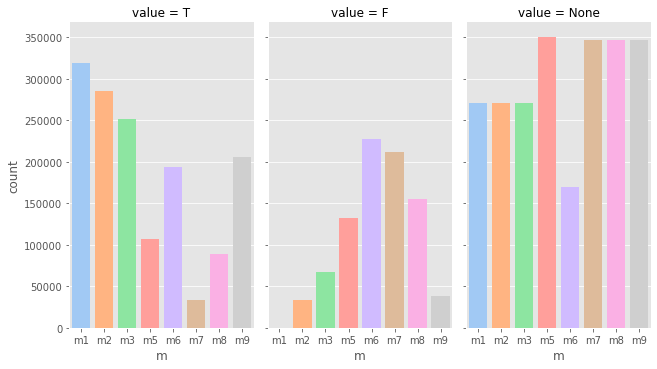

In [188]:
sns.catplot(kind='bar', x="m", y="count", col="value", data=m_value_counts, col_order = ["T", "F", "None"],
            palette="pastel", saturation=1, ci=None, aspect=.6);


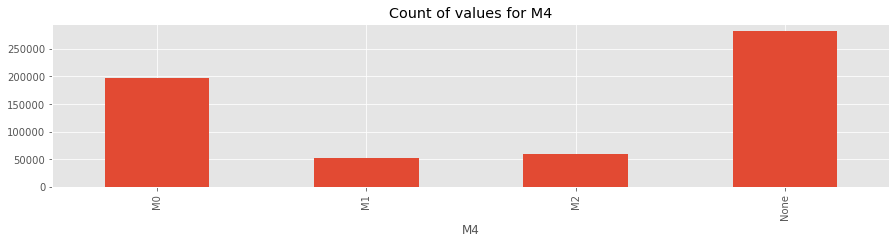

In [202]:
# Looking at M4 column since it is different than the others
m4 = train_transaction[["M4", 'TransactionID']].replace(np.nan, "None")
m4.groupby('M4')['TransactionID']\
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

From above, we can see that missing values seem to be dominant in these features.  

## 1.8 dist1, dist2

In [237]:
train_transaction['dist1'].describe()

count    238269.000000
mean        118.502180
std         371.872026
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64

In [236]:
train_transaction['dist2'].describe()

count    37627.000000
mean       231.855423
std        529.053494
min          0.000000
25%          7.000000
50%         37.000000
75%        206.000000
max      11623.000000
Name: dist2, dtype: float64

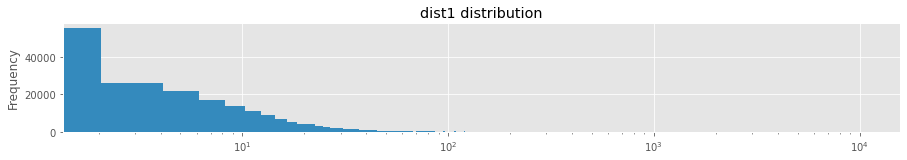

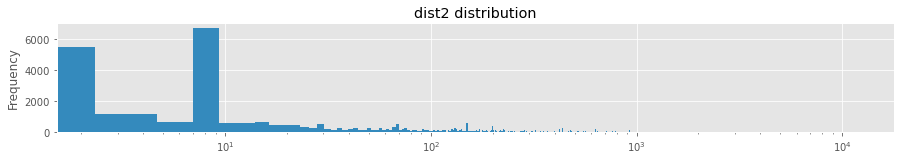

In [235]:
train_transaction['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

- dist 1  and dist 2 might be the distance between transactions or transaction place and billing address. 
- Both distribution are heavily skewed. 
- dist1 has a mode of 0 and dist2 has a mode of 7. 
- Will probably impute missing value with their mode value. 

## 1.9 C1 ~ C14

In [286]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0

In [287]:
train_transaction[c_cols].describe()

C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14  
count  590540.000000  590540.000000  
mean       32.539918       8.295215  
std       129.364844      49.544262  
min         0.000000       0.000000  
25%         1.000000       1.000000  
50%         3.000000       1.000000  
75%        12.000000       2.000000  
max      2918.000000    1429.000000

- These features have different means, std, min and max but no missing value.
- Most of them have high variances as std is higher than its mean. 


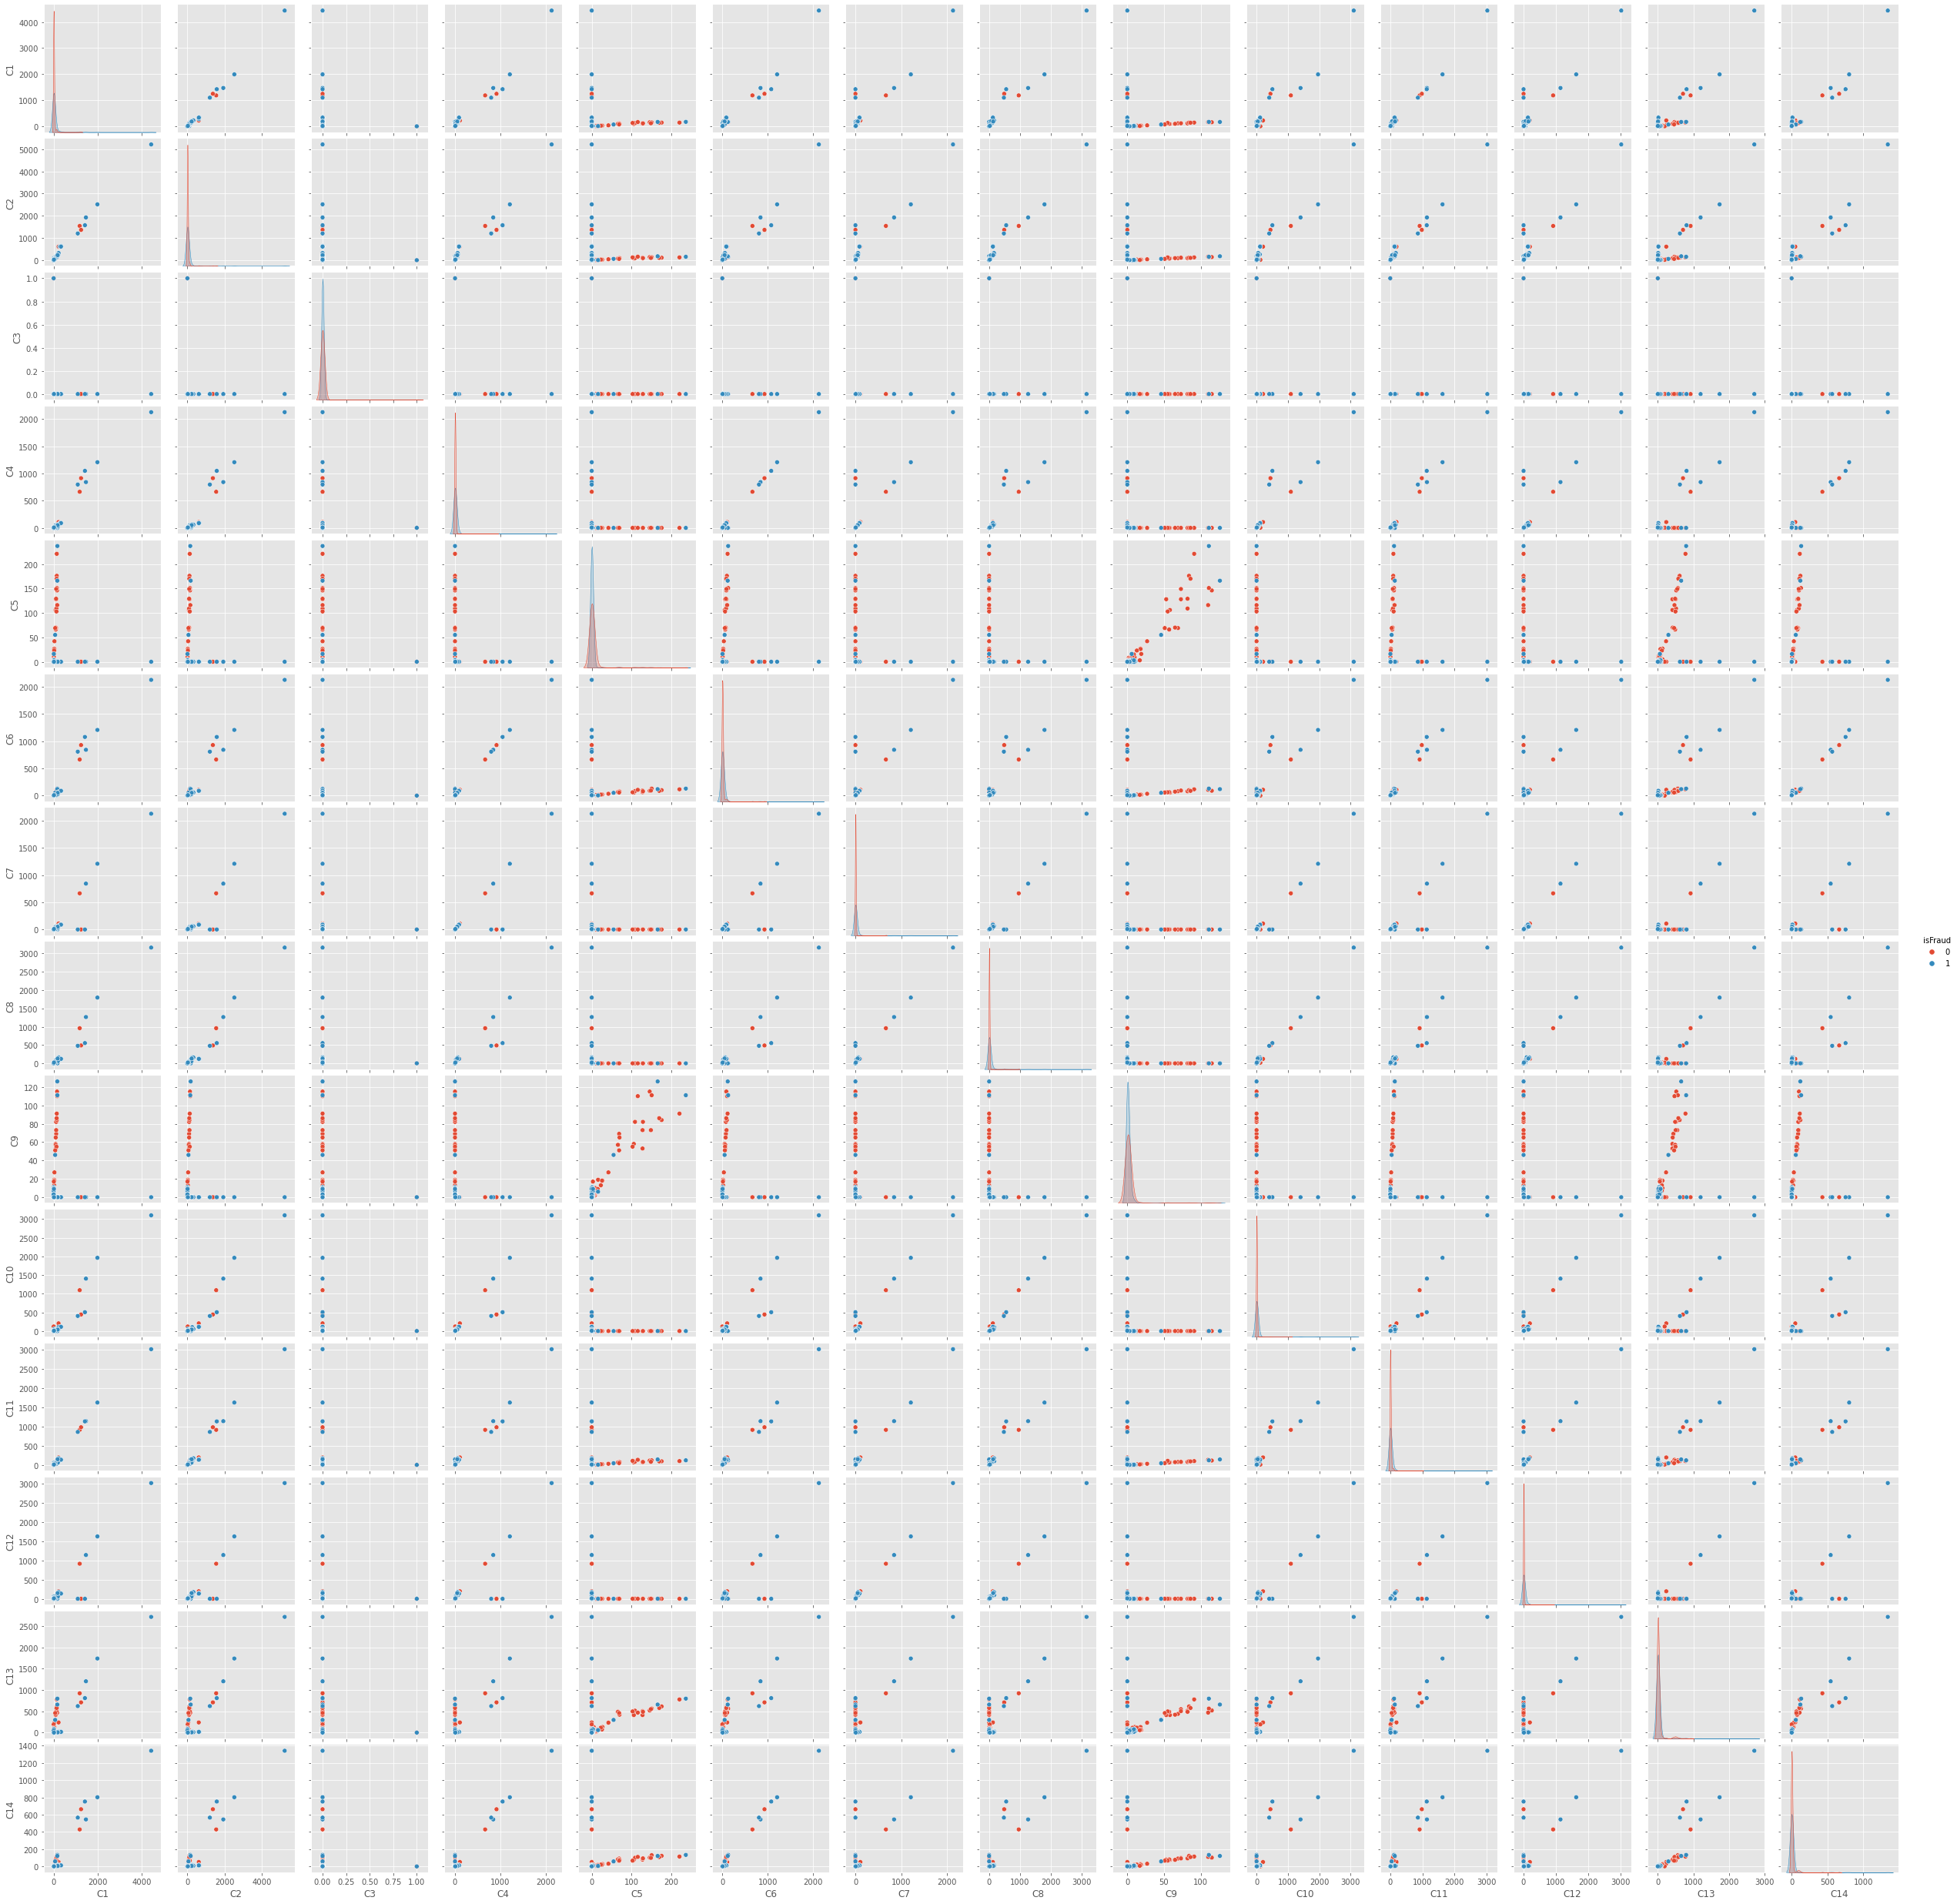

In [284]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

This paired correlation grouped by target plot tests the correlation among C features and their relation with target. C5 and C9 seem to be correlating with most of the other C features. We might consider dropping these features when modeling. 

## 2.0 D1 ~ D15

In [285]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14  \
0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN   
1    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN   
2    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN   
3  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN  NaN  NaN  NaN   
4    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN  NaN  NaN  NaN   

     D15  
0    0.0  
1    0.0  
2  315.0  
3  111.0  
4    NaN

In [288]:
train_transaction[d_cols].describe()

D1             D2             D3             D4  \
count  589271.000000  309743.000000  327662.000000  421618.000000   
mean       94.347568     169.563231      28.343348     140.002441   
std       157.660387     177.315865      62.384721     191.096774   
min         0.000000       0.000000       0.000000    -122.000000   
25%         0.000000      26.000000       1.000000       0.000000   
50%         3.000000      97.000000       8.000000      26.000000   
75%       122.000000     276.000000      27.000000     253.000000   
max       640.000000     640.000000     819.000000     869.000000   

                  D5            D6            D7            D8            D9  \
count  280699.000000  73187.000000  38917.000000  74926.000000  74926.000000   
mean       42.335965     69.805717     41.638950    146.058108      0.561057   
std        89.000144    143.669253     99.743264    231.663840      0.316880   
min         0.000000    -83.000000      0.000000      0.000000      0.000000   
25%         1.000000      0.000000      0.000000      0.958333      0.208333   
50%        10.000000      0.000000      0.000000     37.875000      0.666666   
75%        32.000000     40.000000     17.000000    187.958328      0.833333   
max       819.000000    873.000000    843.000000   1707.791626      0.958333   

                 D10            D11           D12           D13           D14  \
count  514518.000000  311253.000000  64717.000000  61952.000000  62187.000000   
mean      123.982137     146.621465     54.037533     17.901295     57.724444   
std       182.615225     186.042622    124.274558     67.614425    136.312450   
min         0.000000     -53.000000    -83.000000      0.000000   -193.000000   
25%         0.000000       0.000000      0.000000      0.000000      0.000000   
50%        15.000000      43.000000      0.000000      0.000000      0.000000   
75%       197.000000     274.000000     13.000000      0.000000      2.000000   
max       876.000000     670.000000    648.000000    847.000000    878.000000   

                 D15  
count  501427.000000  
mean      163.744579  
std       202.726660  
min       -83.000000  
25%         0.000000  
50%        52.000000  
75%       314.000000  
max       879.000000

- Similar to C features, D features have various ranges of mean, std and min max values.
- Also similar to C features, the variance is high in D features. 

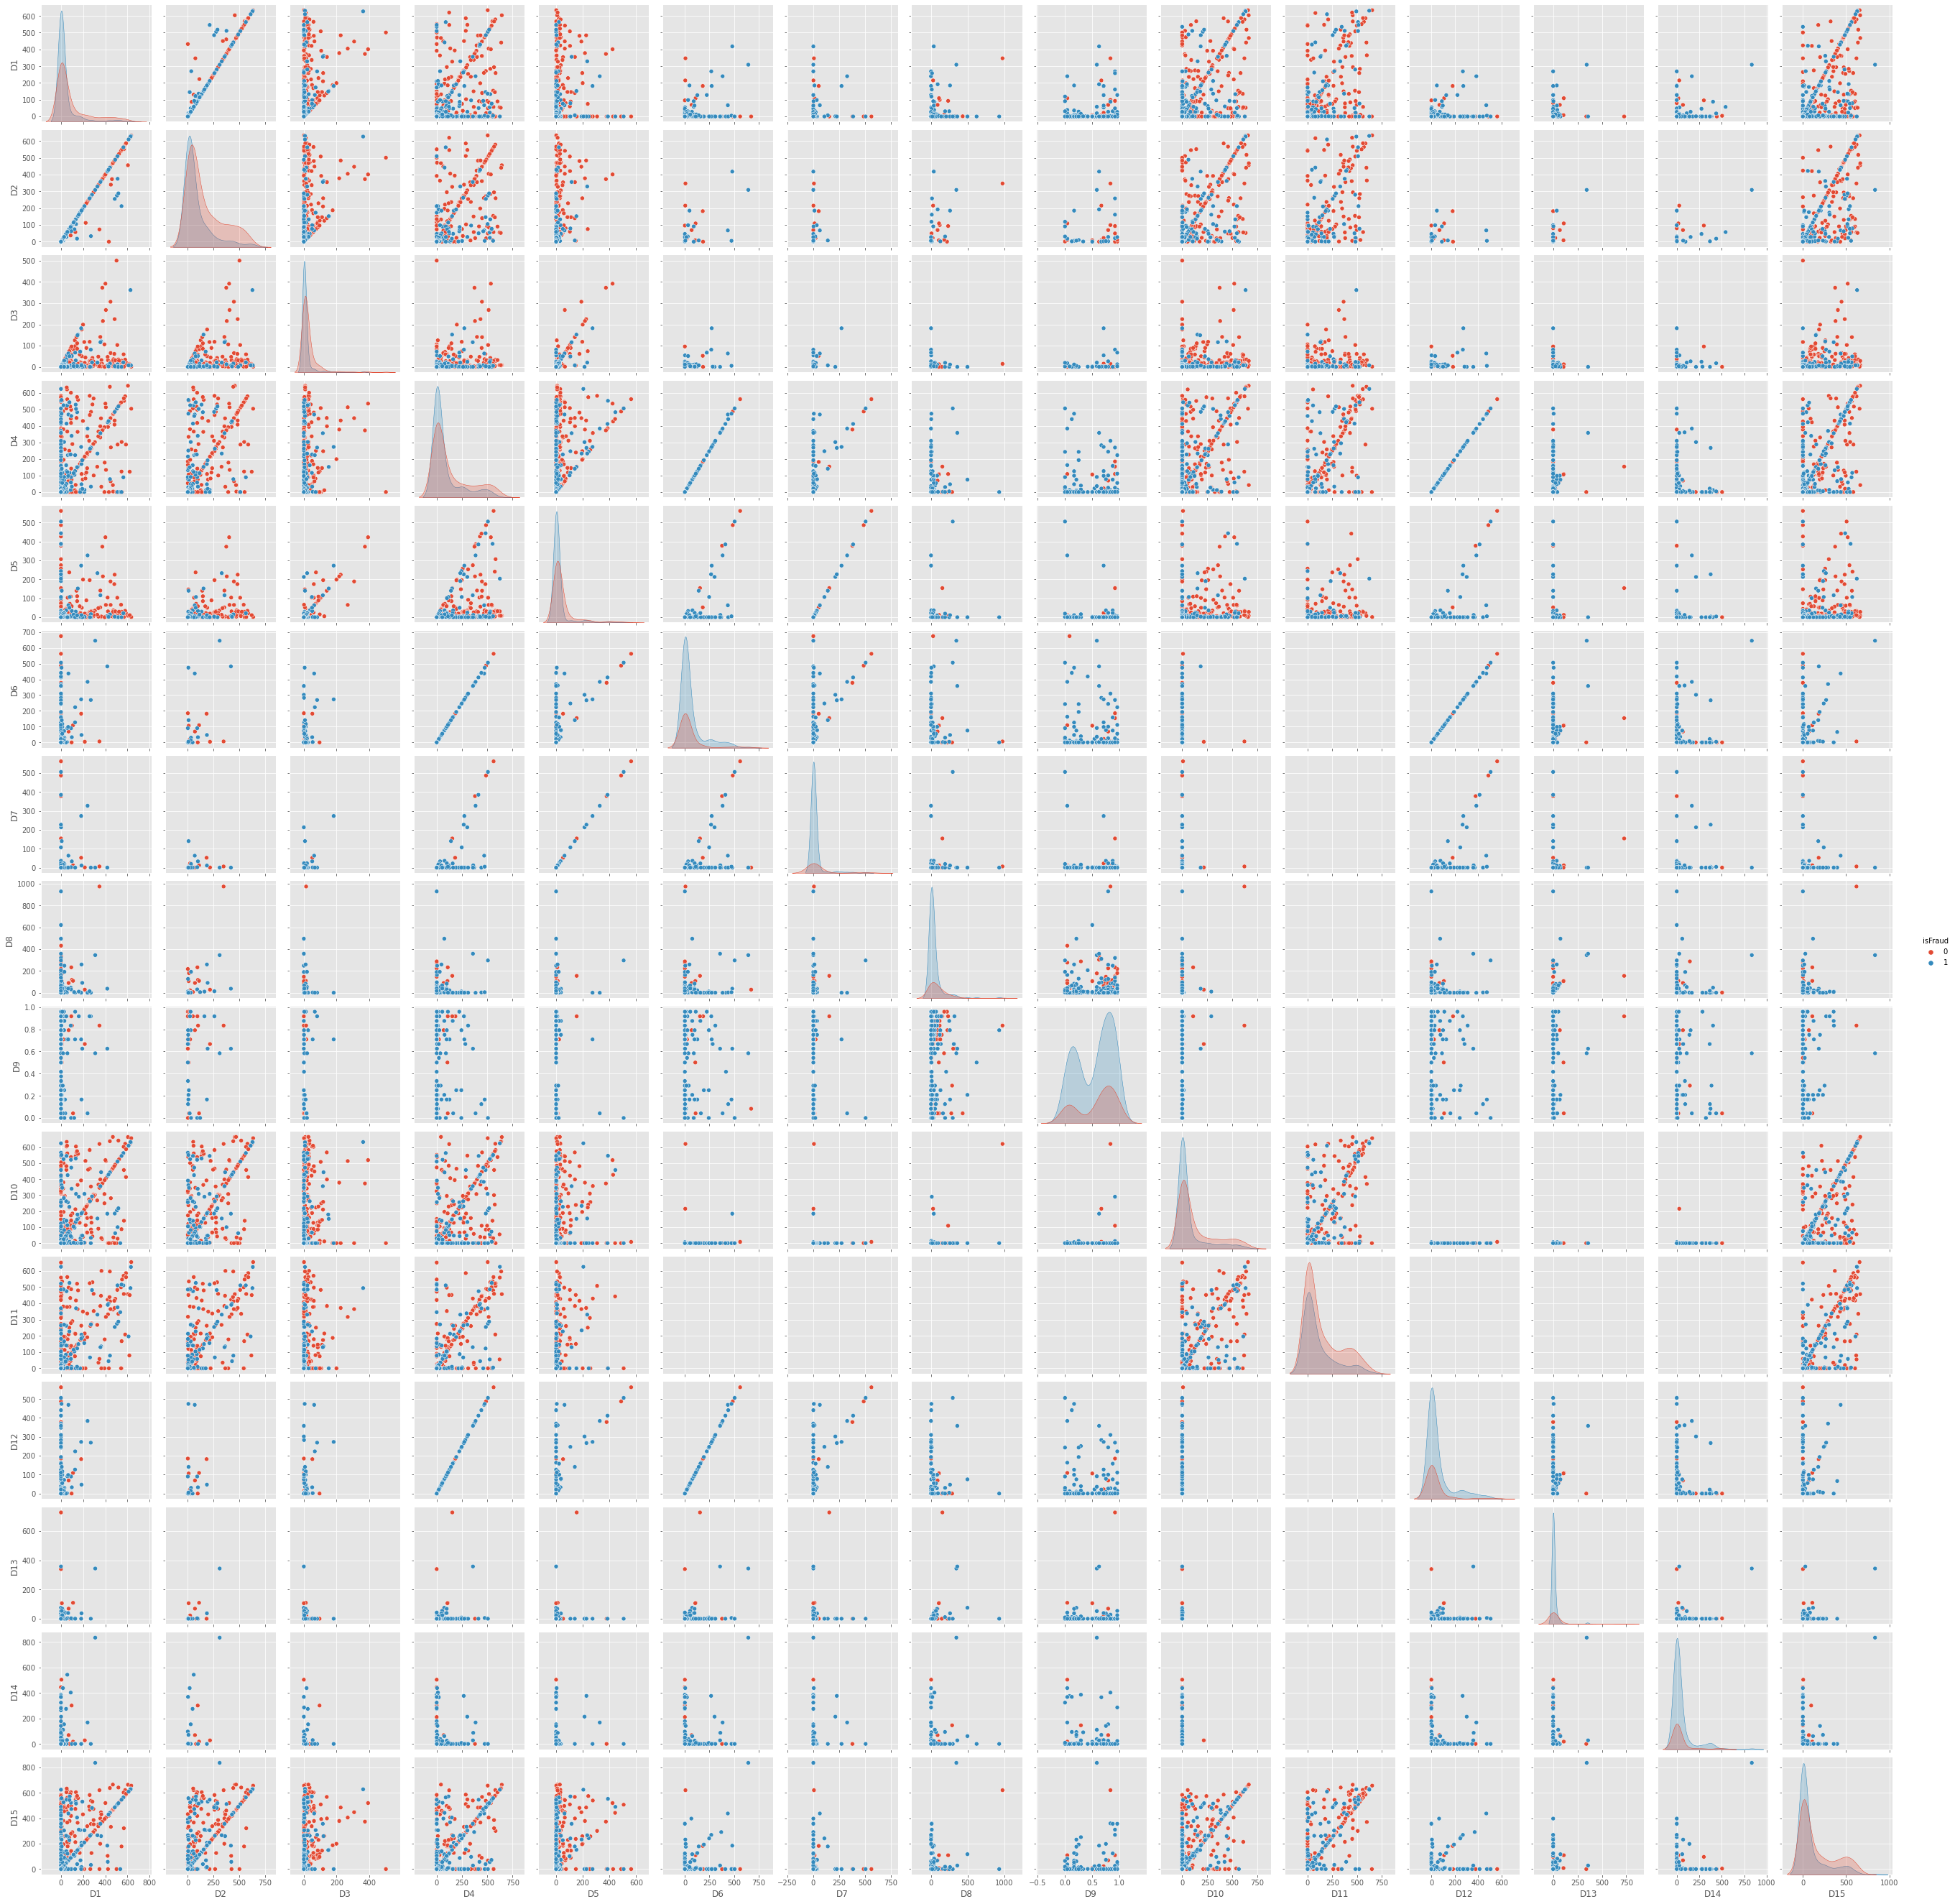

In [289]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

Similarly for features D1-D9. In these paired plots we can see some linear and non-linear interactions between features (particularly in D1~D5, D10, D11, D15). We may want to create additional features using these interactions if we think it would help our model better find relationship between fraud and non-fraud observations. (Such as covariance between features,  mean difference)


## 2.1 V1 ~ V339

In [294]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [295]:
train_transaction[v_cols].describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741883   
std         0.226339       0.521522  ...      4.727971    6217.223583   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

In [323]:
# train_transaction[v_cols].isna().sum(axis=0).plot(kind='barh', figsize=(200,100))

There are a lot of missing values in V features but what's interesting is the number of missing values seem to be the same in groups of V features. (i.e. if V1 is missing a value, V2 ~ V10 are also missing a value). 

In [308]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)
train_transaction['v_mean']

0           3.271605
1           0.313609
2           0.388889
3          66.573964
4         799.648111
             ...    
590535      2.491667
590536      0.388889
590537      0.444444
590538     56.897222
590539     19.263334
Name: v_mean, Length: 590540, dtype: float64

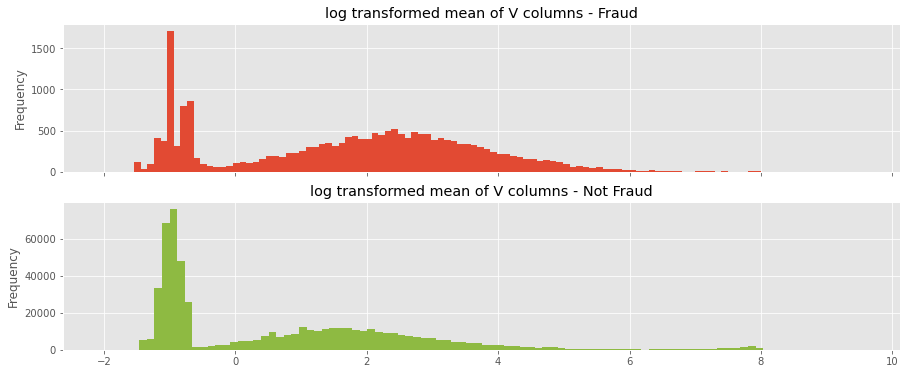

In [320]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

The observation mean of V features in Fraud seem to have a similar distribution as non-fraud transactions. 

## 2.2 Identity Data

As stated earlier, identity data contains customer information. Not all transactions have an corresponding identity. Only around 24% of the transactions have. 

In [324]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


In [325]:
144233/train_transaction.shape[0]

0.2442391709283029

In [327]:
train_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [328]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [329]:
# Add the `isFraud` column for analysis
train_identity_ = train_identity.merge(train_transaction[['TransactionID',
                                                         'TransactionDT',
                                                         'isFraud']],
                                      on=['TransactionID'])

test_identity_ = test_identity.merge(test_transaction[['TransactionID',
                                                      'TransactionDT']],
                                    on=['TransactionID'])

train_identity_

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_08  id_09  ...      id_33           id_34 id_35  id_36  id_37  \
0         NaN    NaN  ...  2220x1080  match_status:2     T      F      T   
1         NaN    NaN  ...   1334x750  match_status:1     T      F      F   
2         NaN    0.0  ...        NaN             NaN     F      F      T   
3         NaN    NaN  ...        NaN             NaN     F      F      T   
4         NaN    0.0  ...   1280x800  match_status:2     T      F      T   
...       ...    ...  ...        ...             ...   ...    ...    ...   
144228    NaN    0.0  ...        NaN             NaN     F      F      T   
144229    NaN    NaN  ...    855x480  match_status:2     T      F      T   
144230    NaN    NaN  ...        NaN             NaN     F      F      T   
144231    NaN    0.0  ...  2560x1600  match_status:2     T      F      T   
144232    NaN    NaN  ...        NaN             NaN     F      F      T   

       id_38 DeviceType                          DeviceInfo  TransactionDT  \
0          T     mobile       SAMSUNG SM-G892A Build/NRD90M          86506   
1          T     mobile                          iOS Device          86535   
2          T    desktop                             Windows          86549   
3          T    desktop                                 NaN          86555   
4          T    desktop                               MacOS          86620   
...      ...        ...                                 ...            ...   
144228     F     mobile             F3111 Build/33.3.A.1.97       15810802   
144229     F     mobile                 A574BL Build/NMF26F       15810876   
144230     F     mobile  Moto E (4) Plus Build/NMA26.42-152       15810912   
144231     F    desktop                               MacOS       15810935   
144232     F     mobile         RNE-L03 Build/HUAWEIRNE-L03       15811030   

        isFraud  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
144228        0  
144229        1  
144230        0  
144231        0  
144232        0  

[144233 rows x 43 columns]

In [331]:
train_identity_.isFraud.mean()

0.07847025299342036

In [332]:
train_transaction.isFraud.mean()

0.03499000914417313

Interestingly, 7.8% with an identity is fraud but only 3.5% of all transactions is fraud. So it seems transactions with an identity is more likely to be fraudulent?

## 2.2.1 Devise Type

In [340]:
train_identity.DeviceType.unique()

array(['mobile', 'desktop', nan], dtype=object)

In [344]:
train_identity_.DeviceType.replace(np.nan, 'None', inplace=True)

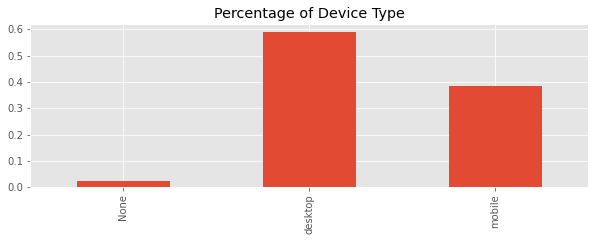

In [362]:
train_identity_.DeviceType.value_counts(normalize=True).sort_index().plot(
    kind='bar', figsize=(10, 3), title="Percentage of Device Type", )
plt.show()

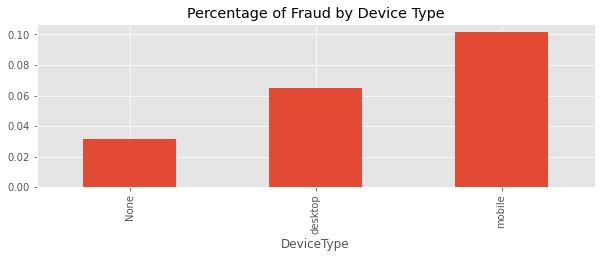

In [363]:
train_identity_.groupby('DeviceType')['isFraud'].mean().sort_index().plot(
    kind='bar', figsize=(10, 3), title="Percentage of Fraud by Device Type")
plt.show()

We can see that mobile payment has a lower % of transactions but higher fraud percentage. 

## 2.2.2 Device Info

In [365]:
len(train_identity.DeviceInfo.unique())

1787

In [367]:
train_identity_.DeviceInfo.replace(np.nan, 'None', inplace=True)

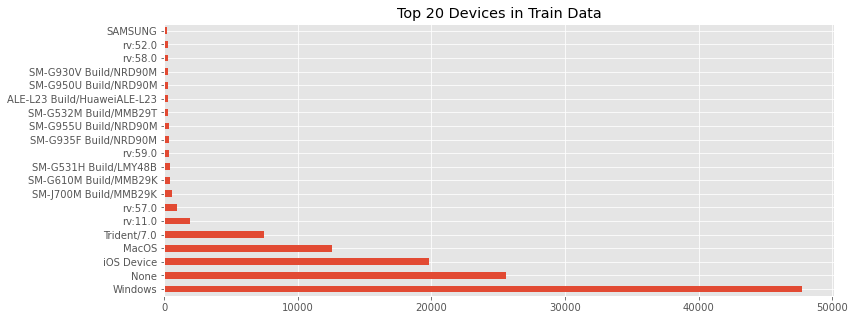

In [408]:
train_identity_.DeviceInfo.value_counts().sort_values(ascending=False)[0:20].plot(
    kind='barh', figsize=(12, 5), title="Top 20 Devices in Train Data" )
plt.show()

## 2.2.3 ID feature

In [418]:
id_cols = [c for c in train_identity.columns if 'id' in c]

In [421]:
train_identity_[id_cols].describe()

id_01          id_02         id_03         id_04  \
count  144233.000000  140872.000000  66324.000000  66324.000000   
mean      -10.170502  174716.584708      0.060189     -0.058938   
std        14.347949  159651.816856      0.598231      0.701015   
min      -100.000000       1.000000    -13.000000    -28.000000   
25%       -10.000000   67992.000000      0.000000      0.000000   
50%        -5.000000  125800.500000      0.000000      0.000000   
75%        -5.000000  228749.000000      0.000000      0.000000   
max         0.000000  999595.000000     10.000000      0.000000   

               id_05          id_06        id_07        id_08         id_09  \
count  136865.000000  136865.000000  5155.000000  5155.000000  74926.000000   
mean        1.615585      -6.698710    13.285354   -38.600388      0.091023   
std         5.249856      16.491104    11.384207    26.084899      0.983842   
min       -72.000000    -100.000000   -46.000000  -100.000000    -36.000000   
25%         0.000000      -6.000000     5.000000   -48.000000      0.000000   
50%         0.000000       0.000000    14.000000   -34.000000      0.000000   
75%         1.000000       0.000000    22.000000   -23.000000      0.000000   
max        52.000000       0.000000    61.000000     0.000000     25.000000   

              id_10  ...          id_17         id_18          id_19  \
count  74926.000000  ...  139369.000000  45113.000000  139318.000000   
mean      -0.301124  ...     189.451377     14.237337     353.128174   
std        2.789446  ...      30.375360      1.561302     141.095343   
min     -100.000000  ...     100.000000     10.000000     100.000000   
25%        0.000000  ...     166.000000     13.000000     266.000000   
50%        0.000000  ...     166.000000     15.000000     341.000000   
75%        0.000000  ...     225.000000     15.000000     427.000000   
max        0.000000  ...     229.000000     29.000000     671.000000   

               id_20        id_21        id_22        id_24        id_25  \
count  139261.000000  5159.000000  5169.000000  4747.000000  5132.000000   
mean      403.882666   368.269820    16.002708    12.800927   329.608924   
std       152.160327   198.847038     6.897665     2.372447    97.461089   
min       100.000000   100.000000    10.000000    11.000000   100.000000   
25%       256.000000   252.000000    14.000000    11.000000   321.000000   
50%       472.000000   252.000000    14.000000    11.000000   321.000000   
75%       533.000000   486.500000    14.000000    15.000000   371.000000   
max       661.000000   854.000000    44.000000    26.000000   548.000000   

             id_26         id_32  
count  5163.000000  77586.000000  
mean    149.070308     26.508597  
std      32.101995      3.737502  
min     100.000000      0.000000  
25%     119.000000     24.000000  
50%     149.000000     24.000000  
75%     169.000000     32.000000  
max     216.000000     32.000000  

[8 rows x 23 columns]

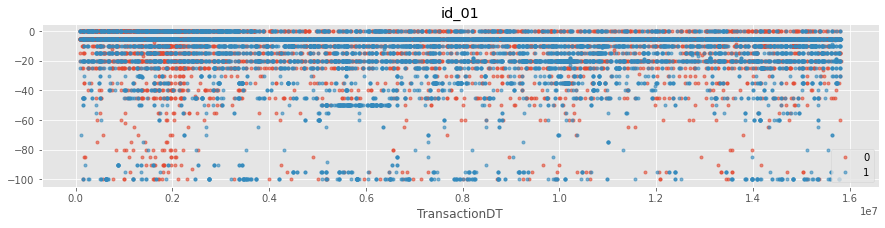

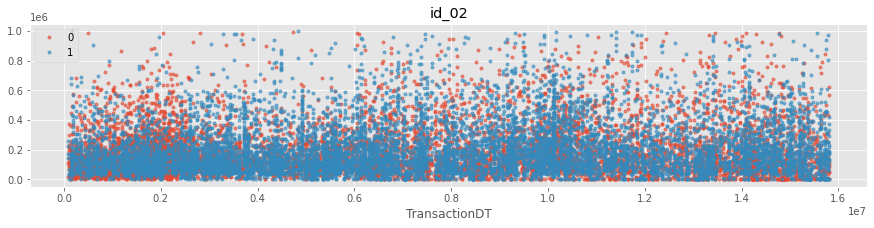

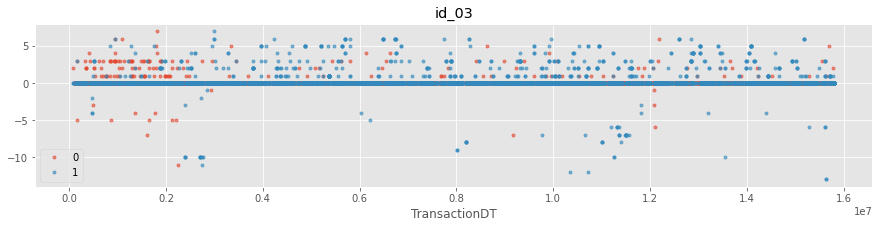

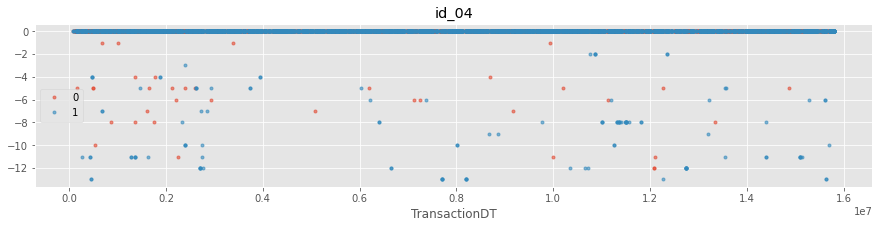

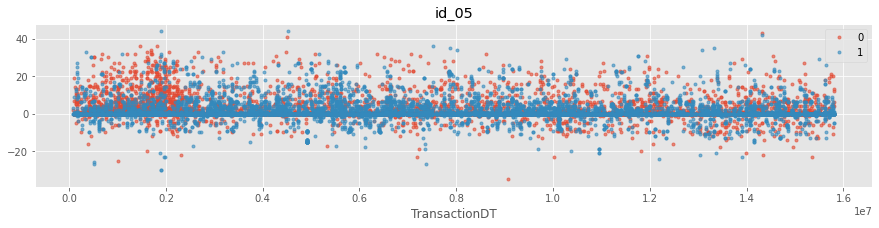

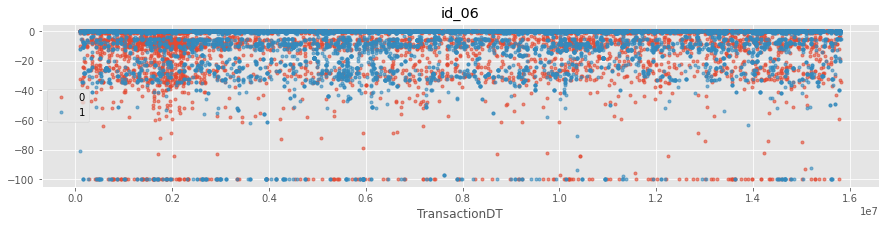

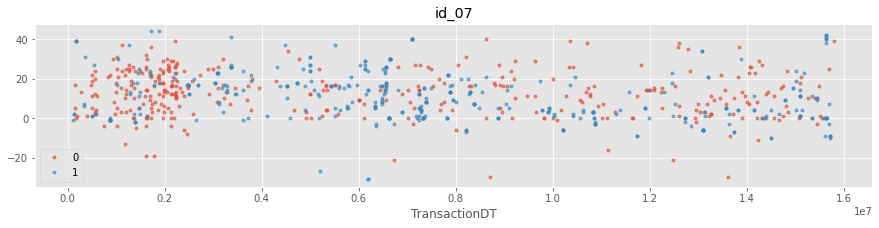

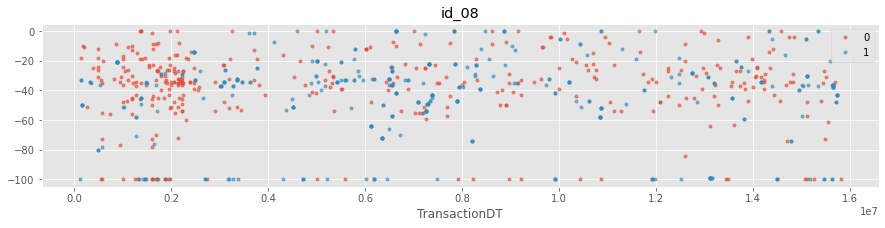

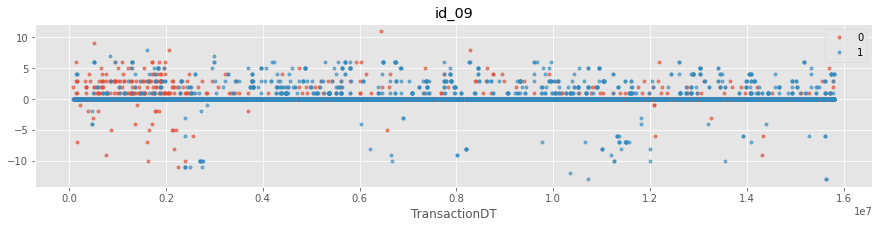

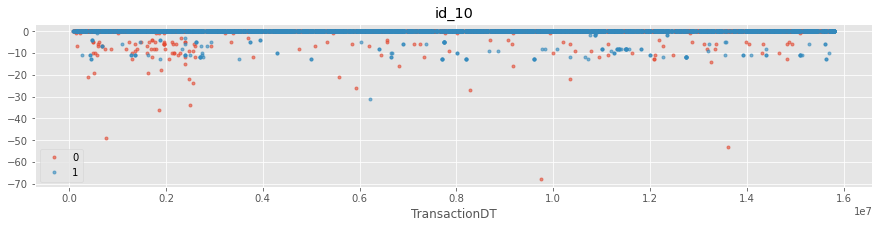

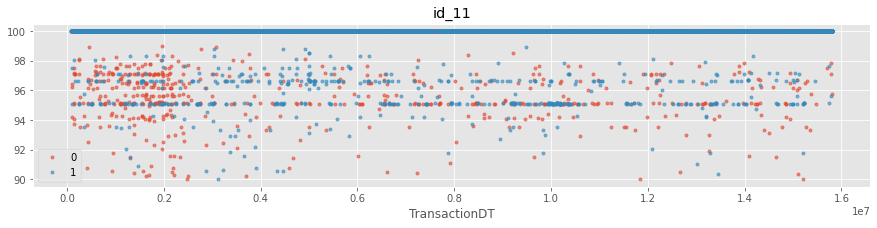

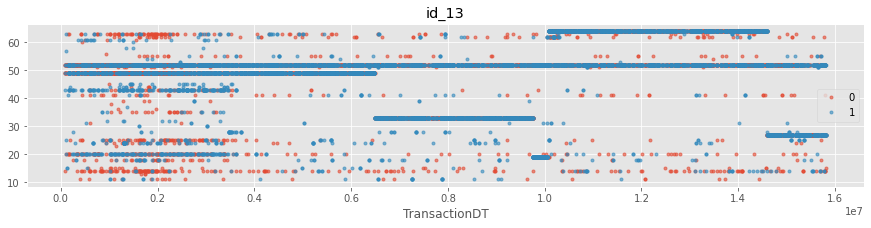

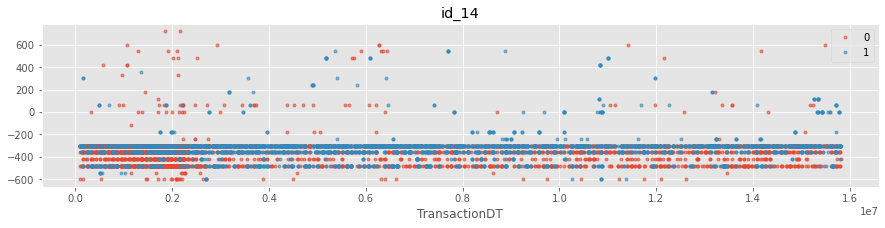

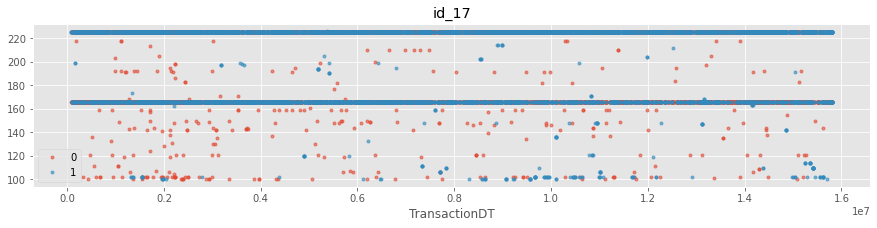

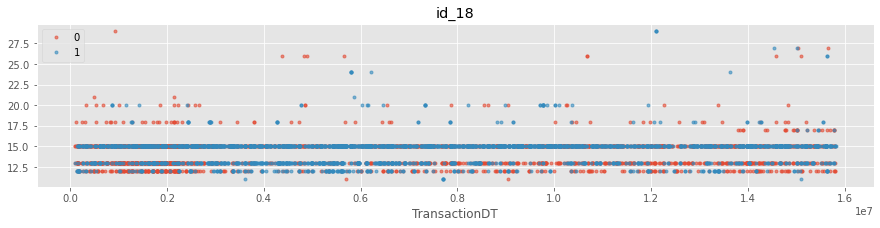

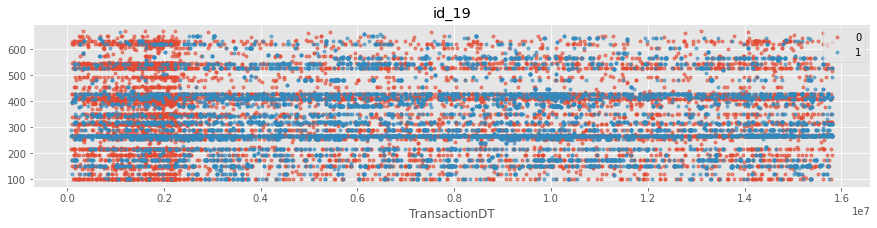

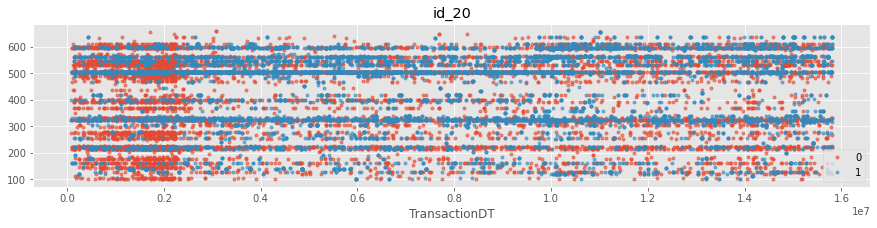

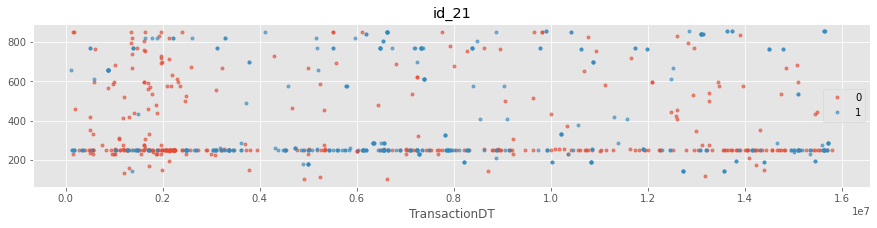

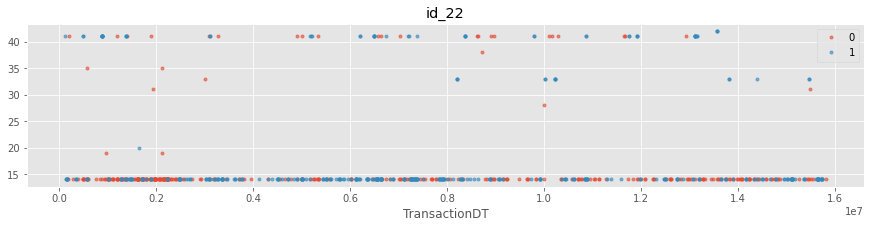

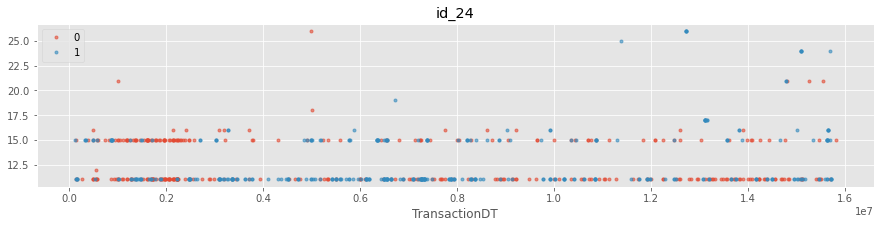

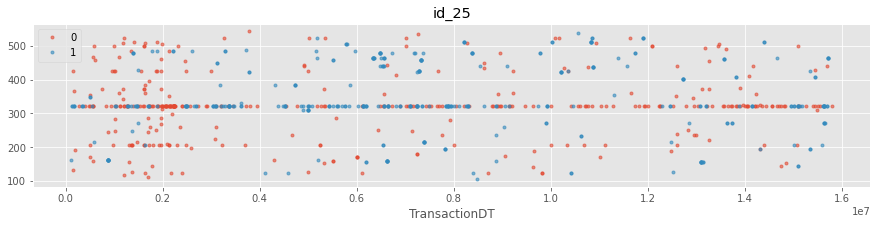

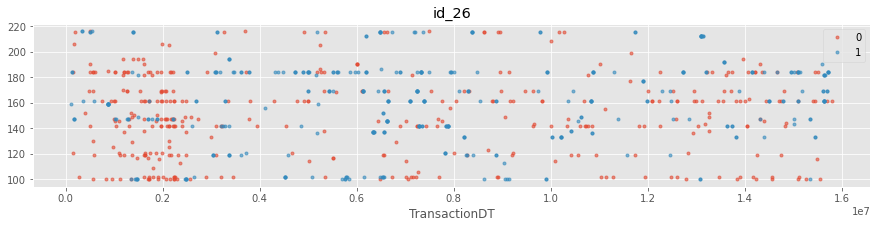

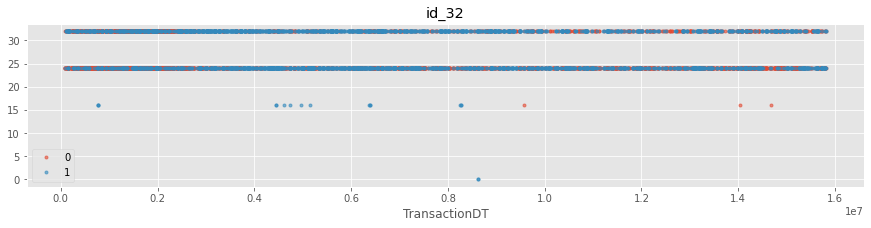

In [450]:
balanced_sample = pd.concat([train_identity_.set_index('TransactionDT').query("isFraud==1").sample(10000), 
           train_identity_.set_index('TransactionDT').query("isFraud==0").sample(10000)])

for i in id_cols:
    try:
        balanced_sample.groupby('isFraud')[i].plot(
            style='.', title=i, figsize=(15, 3), legend=True, alpha=0.6)
        plt.show()
    except TypeError:
        pass

From the original identity data, I took a sample of 5000 from each target group to construct a balanced sample. With the data sample, I plotted the id feature values against transactionDT to observe the feature values over time in different group.

From the above plots, we can observe the id features and transaction time relations. Some id features present more constant values over time, such as 3,4,6,9,10,23,32. Some other id features are more random, because the data points are all over the place over time, such as 2,5,6, 11,13, 19, 20, 21, 25, 26). 